# Assignment 1

## Import Libraries


We will import Relevant libraries which will be use for our porject.

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import math
import os
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import model_selection
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## Checking Device
Set the Device to GPU or CPU.

In [3]:
# Check If the a GPU is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU is not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


# Steps:
## 1. Data loading and normalization

In [4]:
transformation = transforms.Compose([transforms.Resize(30),
                                       transforms.CenterCrop(28),
                                       transforms.Grayscale(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

In [5]:
def loadDataset(data_path,train_size, train_batch_size, val_batch_size, shuffle):
    
    train_data = datasets.ImageFolder(data_path + 'train', transform = transformation)
    test_data = datasets.ImageFolder(data_path + 'test', transform = transformation)
    # diving dataset
    size = len(train_data)
    val_size = 1 - train_size
    # split train_data into train and val data randomly
    train_data, val_data = torch.utils.data.random_split(train_data, [math.ceil(size * train_size), math.ceil(size * val_size)])
    
    print("Training Images : ",len(train_data), "Validation Images",len(val_data), "Testing Images",len(test_data))
    train_loader = DataLoader(train_data,
                          batch_size=train_batch_size,
                          shuffle=shuffle,
                          num_workers=NUM_WORKERS)
    
    val_loader = DataLoader(val_data,
                          batch_size = val_batch_size,
                          shuffle = shuffle,
                          num_workers=NUM_WORKERS)
    
    test_loader = DataLoader(test_data,
                             batch_size=val_batch_size,
                             shuffle=shuffle, # it should be false for testing
                             num_workers=NUM_WORKERS)
    return train_loader, val_loader, test_loader

## 2. Initialize Network

In [6]:
class init_network(nn.Module):
    
    # Constructor
    def __init__(self, no_of_layers, input_dim, neurons_per_layer, dropout):
        super(init_network, self).__init__()
        # adding input layer infornt of list so i can use modulelist
        neurons_per_layer.insert(0,input_dim)
        self.hidden = nn.ModuleList()
        self.drop_layer = nn.Dropout(p=dropout)
        for input_size, output_size in zip(neurons_per_layer, neurons_per_layer[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        
        for (l, linear_transform) in zip(range(L), self.hidden):
            
            if l < L - 1:
                x = F.relu(linear_transform(x))
                x = self.drop_layer(x)
            else:
                x = linear_transform(x)
                x = F.log_softmax(x,dim=1)
                
        return x

## 3. Training and Save Best Model

#### 3.1 Plot Graph

In [7]:
# this function will plot the accuracy and loss graph of training and validation
def plot_loss_and_accuracy_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(history['train_accuracy'], color='royalblue', label='Train Accuracy')
    ax[0].plot(history['val_accuracy'], color='darkred', label='Validation Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], color='royalblue', label='Train Loss')
    ax[1].plot(history['val_loss'], color='darkred', label='Validation Loss')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    plt.show()

#### 3.2 Save model

In [8]:
def save_checkpoint(state, save):
    filename = os.path.join(save, 'model_best.pth.tar')
    torch.save(state, filename)

#### 3.3 Train model and Save Best Model

In [9]:
def train(model, criterion, optimizer, train_loader, validation_loader, model_save_name, epochs=5):
    
    # create the Models folder if it's not exit
    Path(models_path).mkdir(parents=True, exist_ok=True)
    
    # loading the model into device i.e cpu or gpu
    model.to(device)
    # making a copy of model
    best_model = copy.deepcopy(model)
    # Defining the history
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [],
                   'epochs': 0, 'best_val_accuracy': -np.inf, 'min_val_loss': np.inf}

    # defining the variable we will use during the training
    best_val_accuracy = history['best_val_accuracy']
    min_val_loss = history['min_val_loss']

    for epoch in range(0, epochs):  # loop over the dataset multiple times

        train_loss = 0.0
        val_loss = 0.0

        train_accuracy = 0.0
        val_accuracy = 0.0

        correct = 0
        # setting the model in training mode
        model.train()
        # defining the tqdm for displaying the results after every epoch
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch + 1, epochs),
                     position=0, leave=True)

        # iterate over train loader
        for inputs, classes in train_loader:
            # loading the inputs and outputs into device
            inputs, classes = inputs.to(device), classes.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.view(-1, 28 * 28))  # ----> forward pass
            loss = criterion(outputs, classes)  # ----> compute loss

            loss.backward()  # ----> backward pass
            optimizer.step()  # ----> weights update

            # total train loss
            train_loss += loss.item()
            # getting the predicted classes
            _, predicted = torch.max(outputs.data, 1)
            # comparing the predicted classes with actual classes
            correct += (predicted == classes).sum().item()
            # update tqdm
            outer.update(len(inputs))
        outer.close()
        # train accuracy and loss
        train_accuracy = correct / len(train_loader.dataset)
        train_loss = train_loss / len(train_loader)

        # Val loss and accuracy
        with torch.no_grad():
            correct = 0
            # setting model to Evaluation
            model.eval()

            for inputs, classes in validation_loader:
                inputs, classes = inputs.to(device), classes.to(device)
                outputs = model(inputs.view(-1, 28 * 28))  # ----> forward pass

                loss = criterion(outputs, classes)  # ----> compute loss
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == classes).sum().item()

        val_accuracy = correct / len(validation_loader.dataset)
        val_loss = val_loss / len(validation_loader)

        # print statics using tqdm
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str(
            'Train Loss: {:.6f} | Validation Loss: {:.6f} | '
            'Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
                train_loss, val_loss, train_accuracy, val_accuracy))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            min_val_loss = val_loss
            best_model.load_state_dict(model.state_dict())
            save_checkpoint({'history': history, model_save_name:best_model.state_dict()},models_path)

        # update history
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['min_val_loss'] = min_val_loss
        history['best_val_accuracy'] = best_val_accuracy

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    return history, best_model

## 4. Load Network

In [10]:
# this function will be use for loading pretrained model which we create during training.
def load_model(model, path, model_name):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint[model_name])
    history = checkpoint['history']
    return model, history

## 5. Testing

In [11]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
def test(model, data_loader, criterion):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in data_loader:
            images_cpu, classes = data
            images = images_cpu.to(device)
            outputs = model(images.view(-1, 28 * 28))
            # get the prediction class id
            loss = criterion(outputs, classes.to(device))  # ----> compute loss
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
            
#             # For Expriment
#             wrong_predictions = np.where(np.not_equal(predicted, classes))

#             for wrong in wrong_predictions[0].tolist():
#                 imshow(images_cpu[wrong])
#                 print('Predicted Class : ',predicted[wrong])
#                 print('Real Label : ', classes.numpy()[wrong])
                
            # append the predicted and label into list
            y_pred.append(predicted)
            y_true.append(classes)
            
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    test_loss = test_loss / len(data_loader)
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    return y_pred, y_true, test_loss

In [13]:
#### Accuracy Calculation for test

In [14]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

### 6. Visualize Results

In [15]:
def Results(y_pred, y_true):
    print("confusion_matrix : ")
    cm = confusion_matrix(y_true,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    print("classification_report : ")
    print(classification_report(y_true,y_pred))

### 7. Prediction on Single Image
##### 7.1. Image Loading

In [16]:
def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name).convert('RGB') # load single image 
    plt.imshow(image)
    image = transformation(image).float() # apply transformation
    image = Variable(image, requires_grad=True) #Convert it to tensor
    
    # https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
    image = image.unsqueeze(0)   # adding extra dimmention. now shape is [1,3,150,150]
    return image.to(device)  # load it device

##### 7.2. Get prediction

In [17]:
def getPredictedClass(image,model):

    prediction = model(image.view(-1, 28 * 28))
    _, predicted = torch.max(prediction, 1)
    return predicted.cpu().detach().numpy()[0]

## Main Function

In [18]:
def main(data_path,train_size, train_batch_size, val_batch_size, shuffle,no_of_layers, input_dim, neurons_per_layer, dropout, criterion, LR, N_EPOCHS, is_training = False, Visualize_Results = False):
    
    print("Akmal Masud")
    print("Roll No : MSDS19062")
    # create dataset loaders
    train_loader, val_loader, test_loader = loadDataset(data_path, train_size, train_batch_size, val_batch_size, shuffle)
    
    # define network
    Net = init_network(no_of_layers, input_dim, neurons_per_layer,dropout)
    # defining the optimizer
    optimizer = optim.SGD(Net.parameters(), lr=LR, momentum=0.9)
    # if training is true train the model else load train model
    history = None
    if is_training:
        history, Net = train(model=Net,
                                criterion=criterion,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                validation_loader=val_loader,
                                model_save_name=model_name,
                                epochs=N_EPOCHS)
    else:
        path = models_path + 'model_best.pth.tar'
        if os.path.isfile(path):
            Net, history = load_model(Net, path, model_name)
    
    # test on testing data
    y_pred, y_true, test_loss = test(Net, test_loader, criterion=criterion)
    
    print('Test Loss is : ', test_loss)
    print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
        len(test_loader.dataset), 100 * accuracy(y_pred, y_true)))
    # plot graph of accuracy and loss it is true
    if Visualize_Results:
        if history !=None:
            plot_loss_and_accuracy_curves(history)
        Results(y_pred, y_true)
        
#         image_path = './dataset/test/0/1177.png'
#         img = image_loader(image_path)
#         output = getPredictedClass(img,Net)
#         print("Predected Index : ", output)

# Parameters

In [19]:
train_batch_size = 32
val_batch_size = 64
NUM_WORKERS = 3
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 100
train_size = 0.8
shuffle = True
no_of_layers = 2
input_dim = 784
neurons_per_layer = [128 ,10]
dropout = 0.2

models_path = './models/'
data_path = './data/'
model_name = 'minist_2.pth'
criterion = nn.CrossEntropyLoss()

Train Epoch: 1 / 100:   0%|          | 0/720 [00:00<?, ?it/s]

Akmal Masud
Roll No : MSDS19062
Training Images :  720 Validation Images 180 Testing Images 240


Train Epoch: 1 / 100: 100%|██████████| 720/720 [00:01<00:00, 554.15it/s]
Train Loss: 2.326076 | Validation Loss: 2.336694 | Train Accuracy: 0.10 | Validation Accuracy: 0.09
Train Epoch: 2 / 100: 100%|██████████| 720/720 [00:01<00:00, 561.80it/s]
Train Loss: 2.293543 | Validation Loss: 2.340734 | Train Accuracy: 0.13 | Validation Accuracy: 0.09
Train Epoch: 3 / 100: 100%|██████████| 720/720 [00:01<00:00, 549.50it/s]
Train Loss: 2.267320 | Validation Loss: 2.344133 | Train Accuracy: 0.14 | Validation Accuracy: 0.08
Train Epoch: 4 / 100: 100%|██████████| 720/720 [00:01<00:00, 547.95it/s]
Train Loss: 2.240128 | Validation Loss: 2.345031 | Train Accuracy: 0.19 | Validation Accuracy: 0.06
Train Epoch: 5 / 100: 100%|██████████| 720/720 [00:01<00:00, 572.29it/s]
Train Loss: 2.216726 | Validation Loss: 2.349047 | Train Accuracy: 0.20 | Validation Accuracy: 0.06
Train Epoch: 6 / 100: 100%|██████████| 720/720 [00:01<00:00, 578.68it/s]
Train Loss: 2.203891 | Validation Loss: 2.344461 | Train Accur

Train Epoch: 95 / 100: 100%|██████████| 720/720 [00:01<00:00, 580.19it/s]
Train Loss: 0.910006 | Validation Loss: 2.954884 | Train Accuracy: 0.77 | Validation Accuracy: 0.11
Train Epoch: 96 / 100: 100%|██████████| 720/720 [00:01<00:00, 569.12it/s]
Train Loss: 0.894800 | Validation Loss: 2.975149 | Train Accuracy: 0.76 | Validation Accuracy: 0.12
Train Epoch: 97 / 100: 100%|██████████| 720/720 [00:01<00:00, 579.25it/s]
Train Loss: 0.883497 | Validation Loss: 3.004430 | Train Accuracy: 0.77 | Validation Accuracy: 0.11
Train Epoch: 98 / 100: 100%|██████████| 720/720 [00:01<00:00, 580.18it/s]
Train Loss: 0.889735 | Validation Loss: 2.993687 | Train Accuracy: 0.78 | Validation Accuracy: 0.12
Train Epoch: 99 / 100: 100%|██████████| 720/720 [00:01<00:00, 583.00it/s]
Train Loss: 0.836881 | Validation Loss: 3.027171 | Train Accuracy: 0.79 | Validation Accuracy: 0.11
Train Epoch: 100 / 100: 100%|██████████| 720/720 [00:01<00:00, 552.57it/s]
Train Loss: 0.826667 | Validation Loss: 3.027864 | Trai

Test Loss is :  2.9758628010749817
Accuracy of the network on the 240 test images: 11.67 %


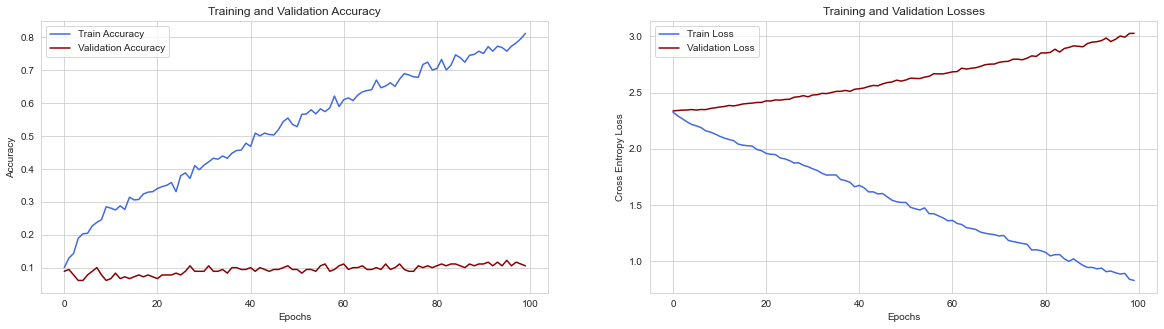

confusion_matrix : 


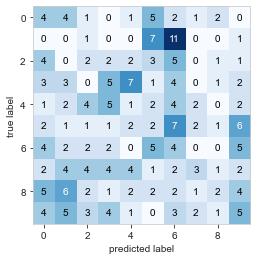

classification_report : 
              precision    recall  f1-score   support

           0       0.14      0.20      0.16        20
           1       0.00      0.00      0.00        20
           2       0.10      0.10      0.10        20
           3       0.21      0.19      0.20        26
           4       0.05      0.04      0.05        23
           5       0.07      0.08      0.08        25
           6       0.09      0.17      0.12        24
           7       0.27      0.11      0.16        27
           8       0.22      0.07      0.11        27
           9       0.18      0.18      0.18        28

    accuracy                           0.12       240
   macro avg       0.13      0.11      0.12       240
weighted avg       0.14      0.12      0.12       240



In [25]:
main(data_path,train_size, train_batch_size, val_batch_size, shuffle,no_of_layers, input_dim, neurons_per_layer, dropout, criterion, LR, N_EPOCHS, is_training, Visualize_Results)